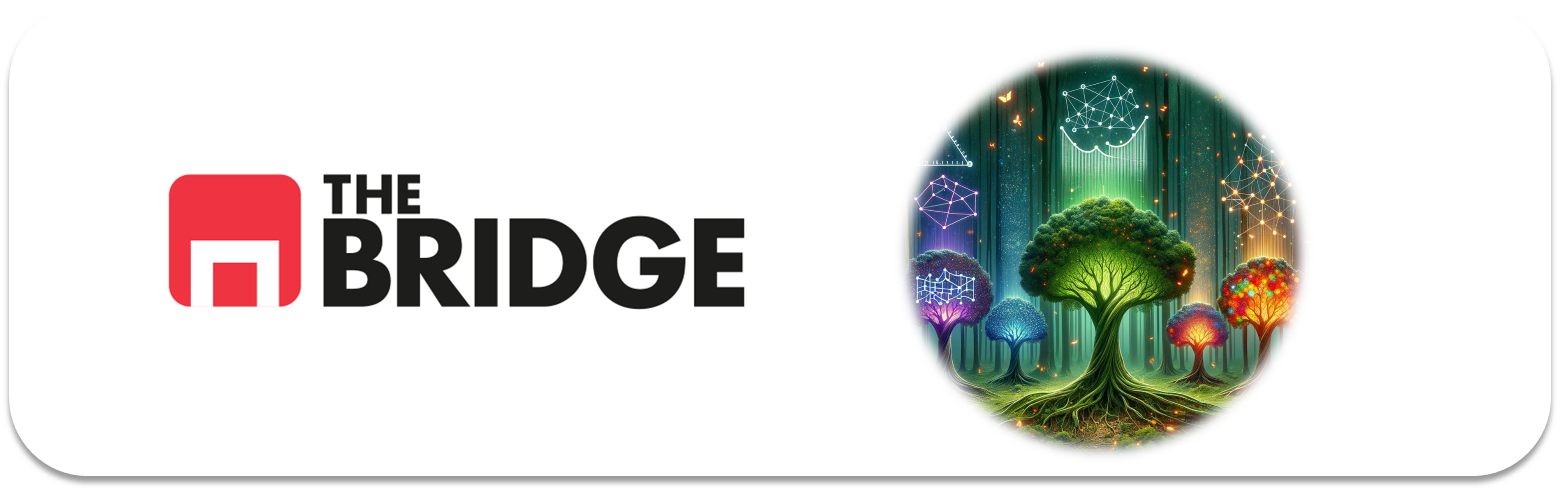

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [3]:
# Cargar datos y visualizar
data = pd.read_csv('./data/bank-full.csv',sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
data.info() # no hay valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
# Identificar la variable target y transformarla a binaria
target_col = 'y'

# Convertir la variable target a binaria (si es necesario)
data[target_col] = data[target_col].map({'yes': 1, 'no': 0})

In [6]:
# Separar características (X) y variable target (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

##### Análisis de la variable target

Distribución de la variable target en el conjunto de entrenamiento:
y
0    0.883022
1    0.116978
Name: proportion, dtype: float64


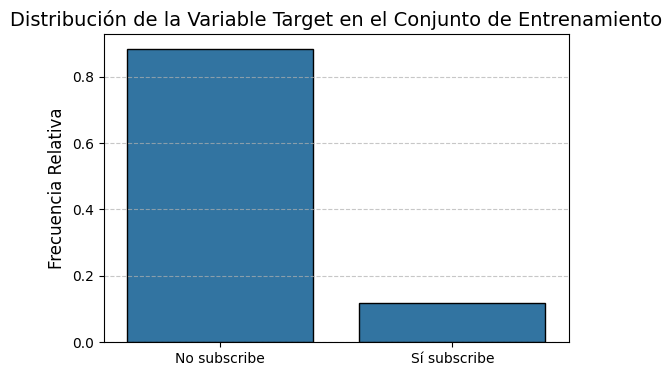

In [7]:
# Analizar la distribución de la variable target en el conjunto de entrenamiento
target_fre = y_train.value_counts(normalize=True)
print(f"Distribución de la variable target en el conjunto de entrenamiento:\n{target_fre}")

plt.figure(figsize=(6, 4))
sns.barplot(
    x=target_fre.index, 
    y=target_fre.values, 
    edgecolor='black'
)

plt.title("Distribución de la Variable Target en el Conjunto de Entrenamiento", fontsize=14)
plt.xlabel("")
plt.ylabel("Frecuencia Relativa", fontsize=12)
plt.xticks([0, 1], labels=["No subscribe", "Sí subscribe"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


##### Análisis de las variables features

In [8]:
# Crear un DataFrame combinado para EDA
train_data = X_train.copy()
train_data['target'] = y_train
train_data
train_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 31647 entries, 13382 to 3184
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        31647 non-null  int64 
 1   job        31647 non-null  object
 2   marital    31647 non-null  object
 3   education  31647 non-null  object
 4   default    31647 non-null  object
 5   balance    31647 non-null  int64 
 6   housing    31647 non-null  object
 7   loan       31647 non-null  object
 8   contact    31647 non-null  object
 9   day        31647 non-null  int64 
 10  month      31647 non-null  object
 11  duration   31647 non-null  int64 
 12  campaign   31647 non-null  int64 
 13  pdays      31647 non-null  int64 
 14  previous   31647 non-null  int64 
 15  poutcome   31647 non-null  object
 16  target     31647 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 4.3+ MB


In [9]:
# Identificar variables categóricas y numéricas
categorical_features = train_data.select_dtypes(include=['object']).columns
categorical_features


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [10]:
numerical_features = train_data.select_dtypes(include=['float', 'int']).columns
numerical_features


Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'target'],
      dtype='object')

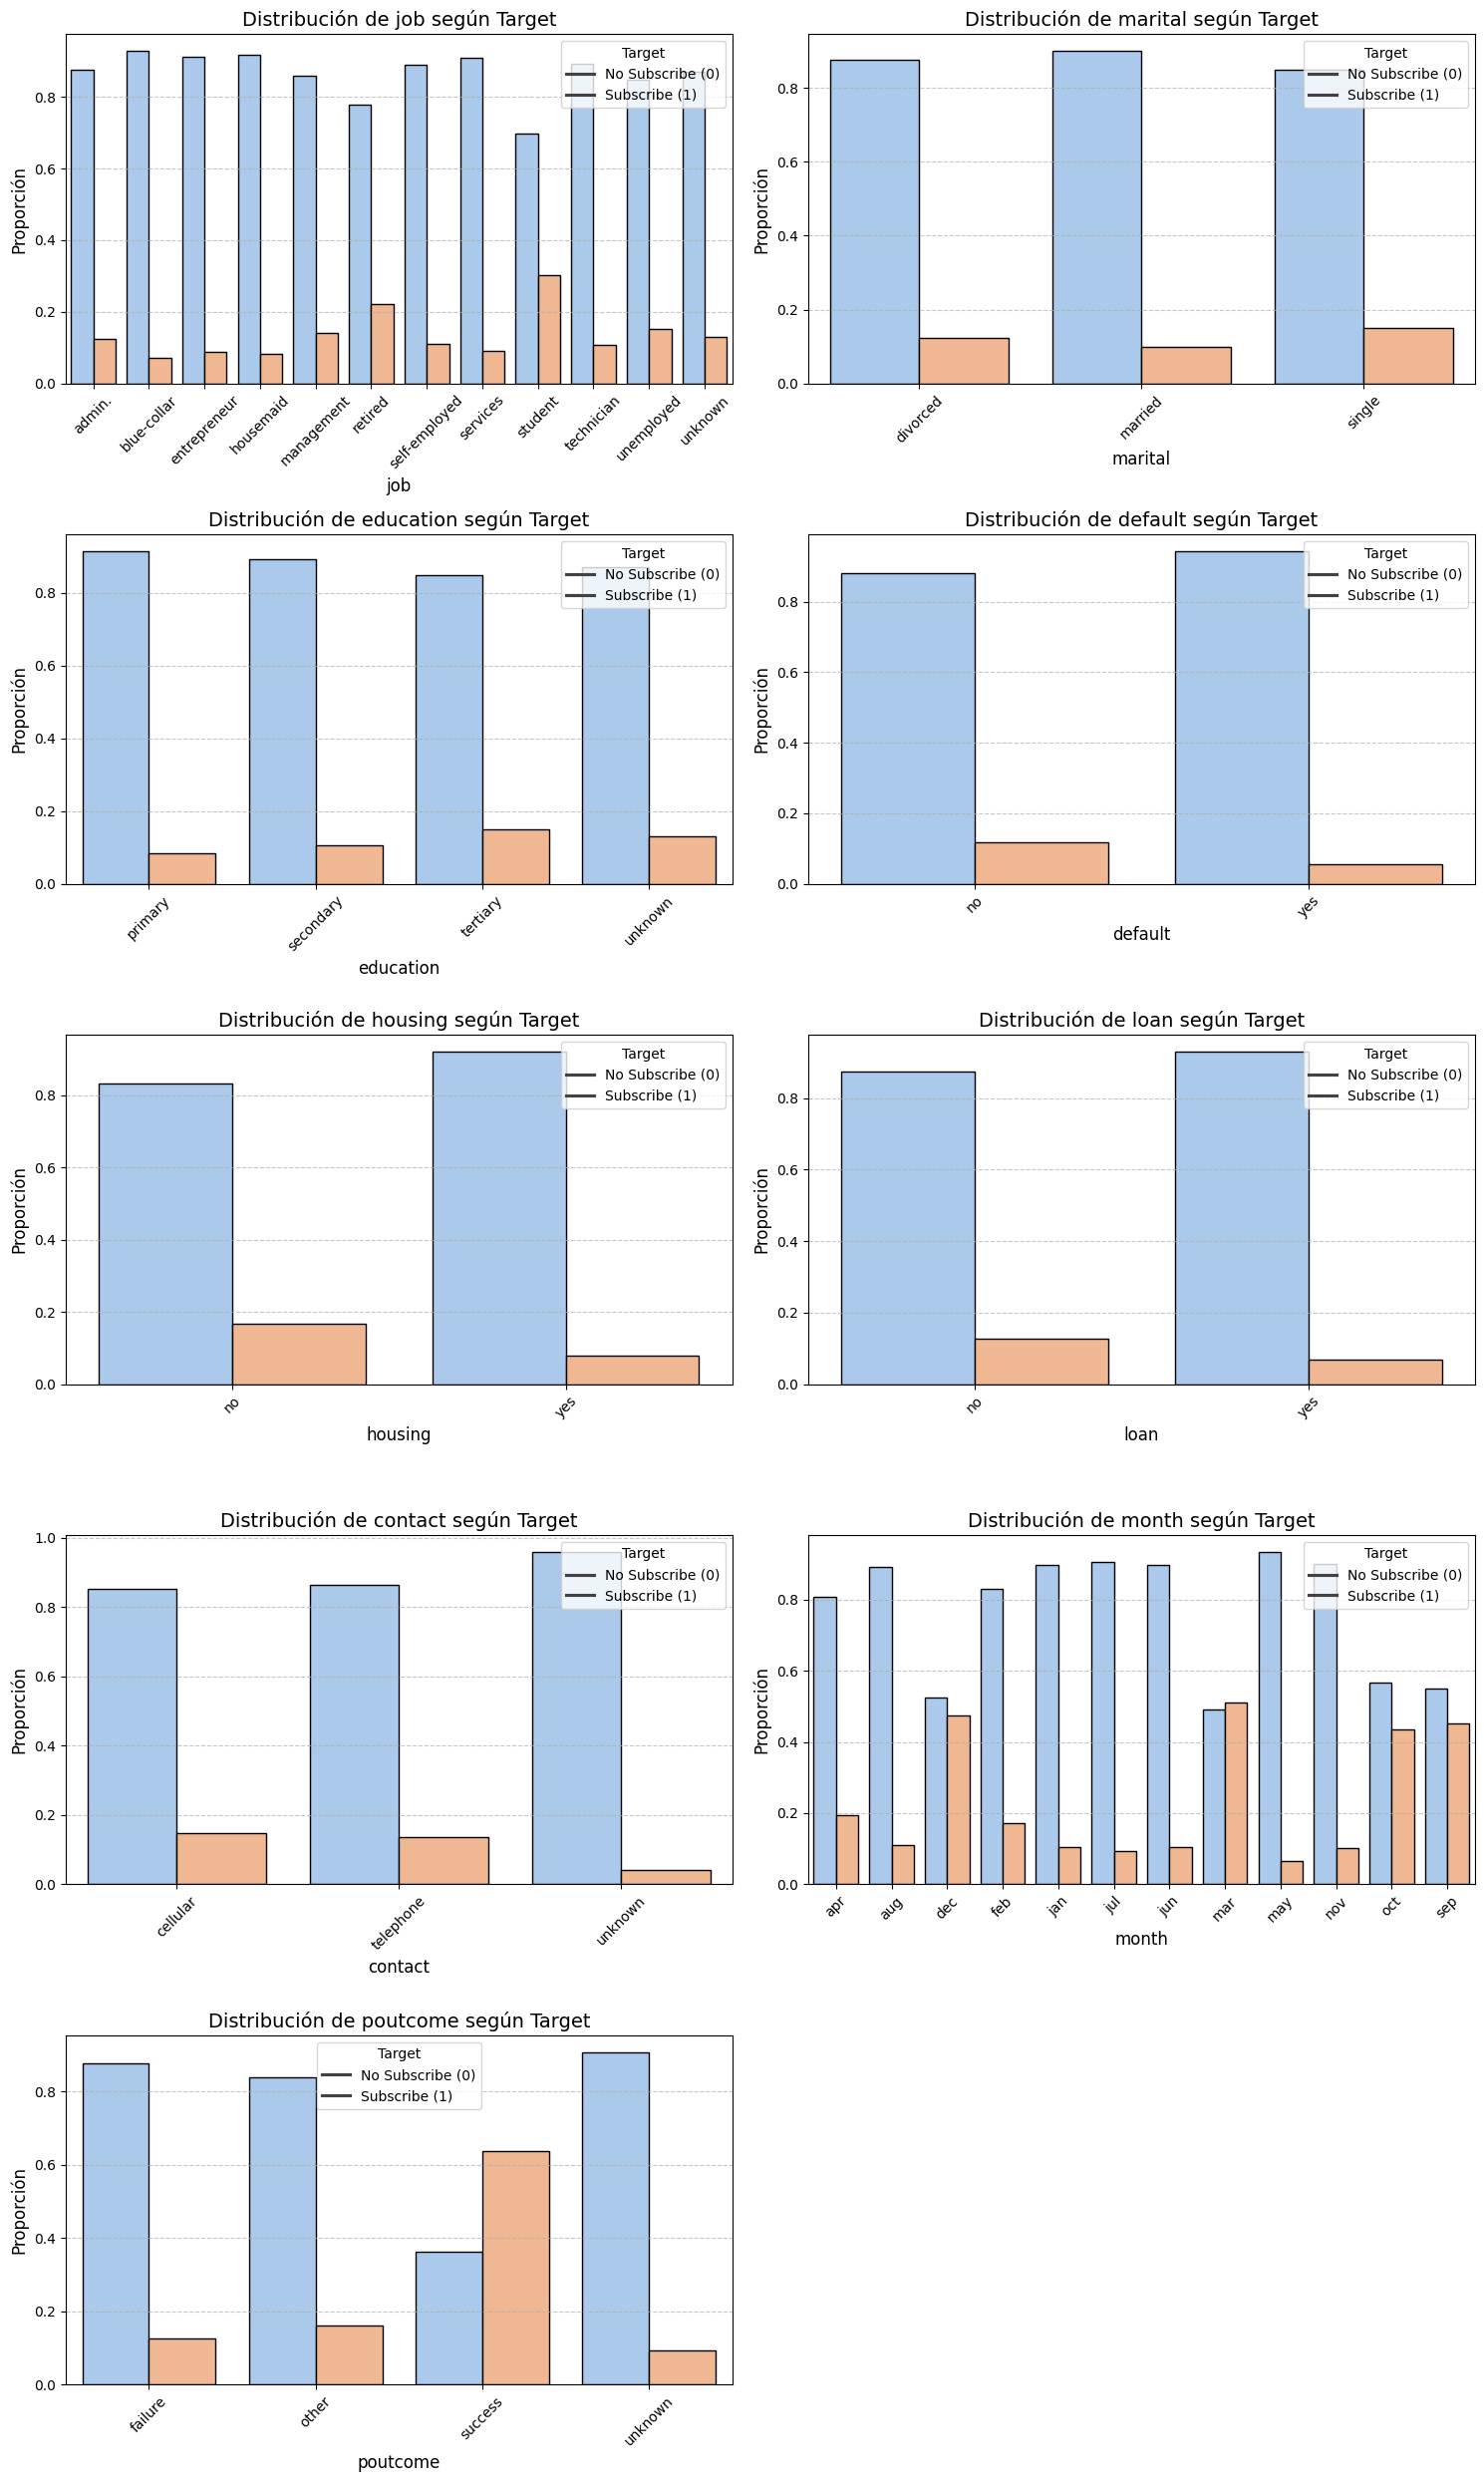

In [11]:
### 1. Análisis bivariante target - variables categóricas
# Determinar el número de filas y columnas
n_features = len(categorical_features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

# Crear la figura y los subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Generar gráficos para cada variable categórica
for i, feature in enumerate(categorical_features):
    # Calcular proporciones por categoría y target
    data_grouped = train_data.groupby([feature, 'target']).size().reset_index(name='count')
    data_grouped['percentage'] = data_grouped['count'] / data_grouped.groupby(feature)['count'].transform('sum')
    
    # Crear gráfico de barras
    sns.barplot(
        x=feature,
        y='percentage',
        hue='target',
        data=data_grouped,
        palette='pastel',
        edgecolor='black',
        ax=axes[i]
    )
    
    # Personalización del gráfico
    axes[i].set_title(f"Distribución de {feature} según Target", fontsize=14)
    axes[i].set_ylabel("Proporción", fontsize=12)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].legend(title="Target", labels=["No Subscribe (0)", "Subscribe (1)"])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Ocultar ejes vacíos si el número de gráficos es impar
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [12]:
# Realizar el test de Chi-cuadrado
print("Resultados del test de Chi-cuadrado:\n")
chi2_results = []

for feature in categorical_features:
    # Crear tabla de contingencia
    contingency_table = pd.crosstab(train_data[feature], train_data['target'])
    
    # Realizar el test de Chi-cuadrado
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Guardar resultados
    chi2_results.append({'Variable': feature, 'Chi2': chi2, 'p-value': p_value, 'Degrees of Freedom': dof})
    
    # Imprimir resultados para cada variable
    print(f"Variable: {feature}")
    print(f"  Chi2: {chi2:.4f}")
    print(f"  p-value: {p_value:.4e}")
    print(f"  Degrees of Freedom: {dof}")
    print(f"{'Significativo' if p_value < 0.05 else 'No significativo'}\n")

# Convertir resultados a un DataFrame para mayor claridad (opcional)
chi2_df = pd.DataFrame(chi2_results)


Resultados del test de Chi-cuadrado:

Variable: job
  Chi2: 616.8115
  p-value: 3.5453e-125
  Degrees of Freedom: 11
Significativo

Variable: marital
  Chi2: 160.3061
  p-value: 1.5487e-35
  Degrees of Freedom: 2
Significativo

Variable: education
  Chi2: 166.8915
  p-value: 5.9662e-36
  Degrees of Freedom: 3
Significativo

Variable: default
  Chi2: 19.5844
  p-value: 9.6252e-06
  Degrees of Freedom: 1
Significativo

Variable: housing
  Chi2: 588.9163
  p-value: 4.3115e-130
  Degrees of Freedom: 1
Significativo

Variable: loan
  Chi2: 133.1256
  p-value: 8.4868e-31
  Degrees of Freedom: 1
Significativo

Variable: contact
  Chi2: 723.2455
  p-value: 8.8967e-158
  Degrees of Freedom: 2
Significativo

Variable: month
  Chi2: 2088.9121
  p-value: 0.0000e+00
  Degrees of Freedom: 11
Significativo

Variable: poutcome
  Chi2: 2933.3971
  p-value: 0.0000e+00
  Degrees of Freedom: 3
Significativo



* Se incluyen todas las categóricas

In [13]:
### 2. Análisis de correlación entre variables numéricas
# Calcular la matriz de correlación
correlation_matrix = train_data[numerical_features].corr()

# Extraer las correlaciones con la variable target
target_correlation = correlation_matrix['target'].drop('target')

# Crear un DataFrame con las correlaciones ordenadas
correlation_df = target_correlation.abs().sort_values(ascending=False).to_frame(name='Correlation')
correlation_df['Correlation_Signed'] = target_correlation  # Añadimos los signos originales

# Mostrar el DataFrame
correlation_df


,Correlation,Correlation_Signed
duration,0.398404,0.398404
pdays,0.098897,0.098897
previous,0.084945,0.084945
campaign,0.072185,-0.072185
balance,0.056386,0.056386
day,0.026452,-0.026452
age,0.019217,0.019217


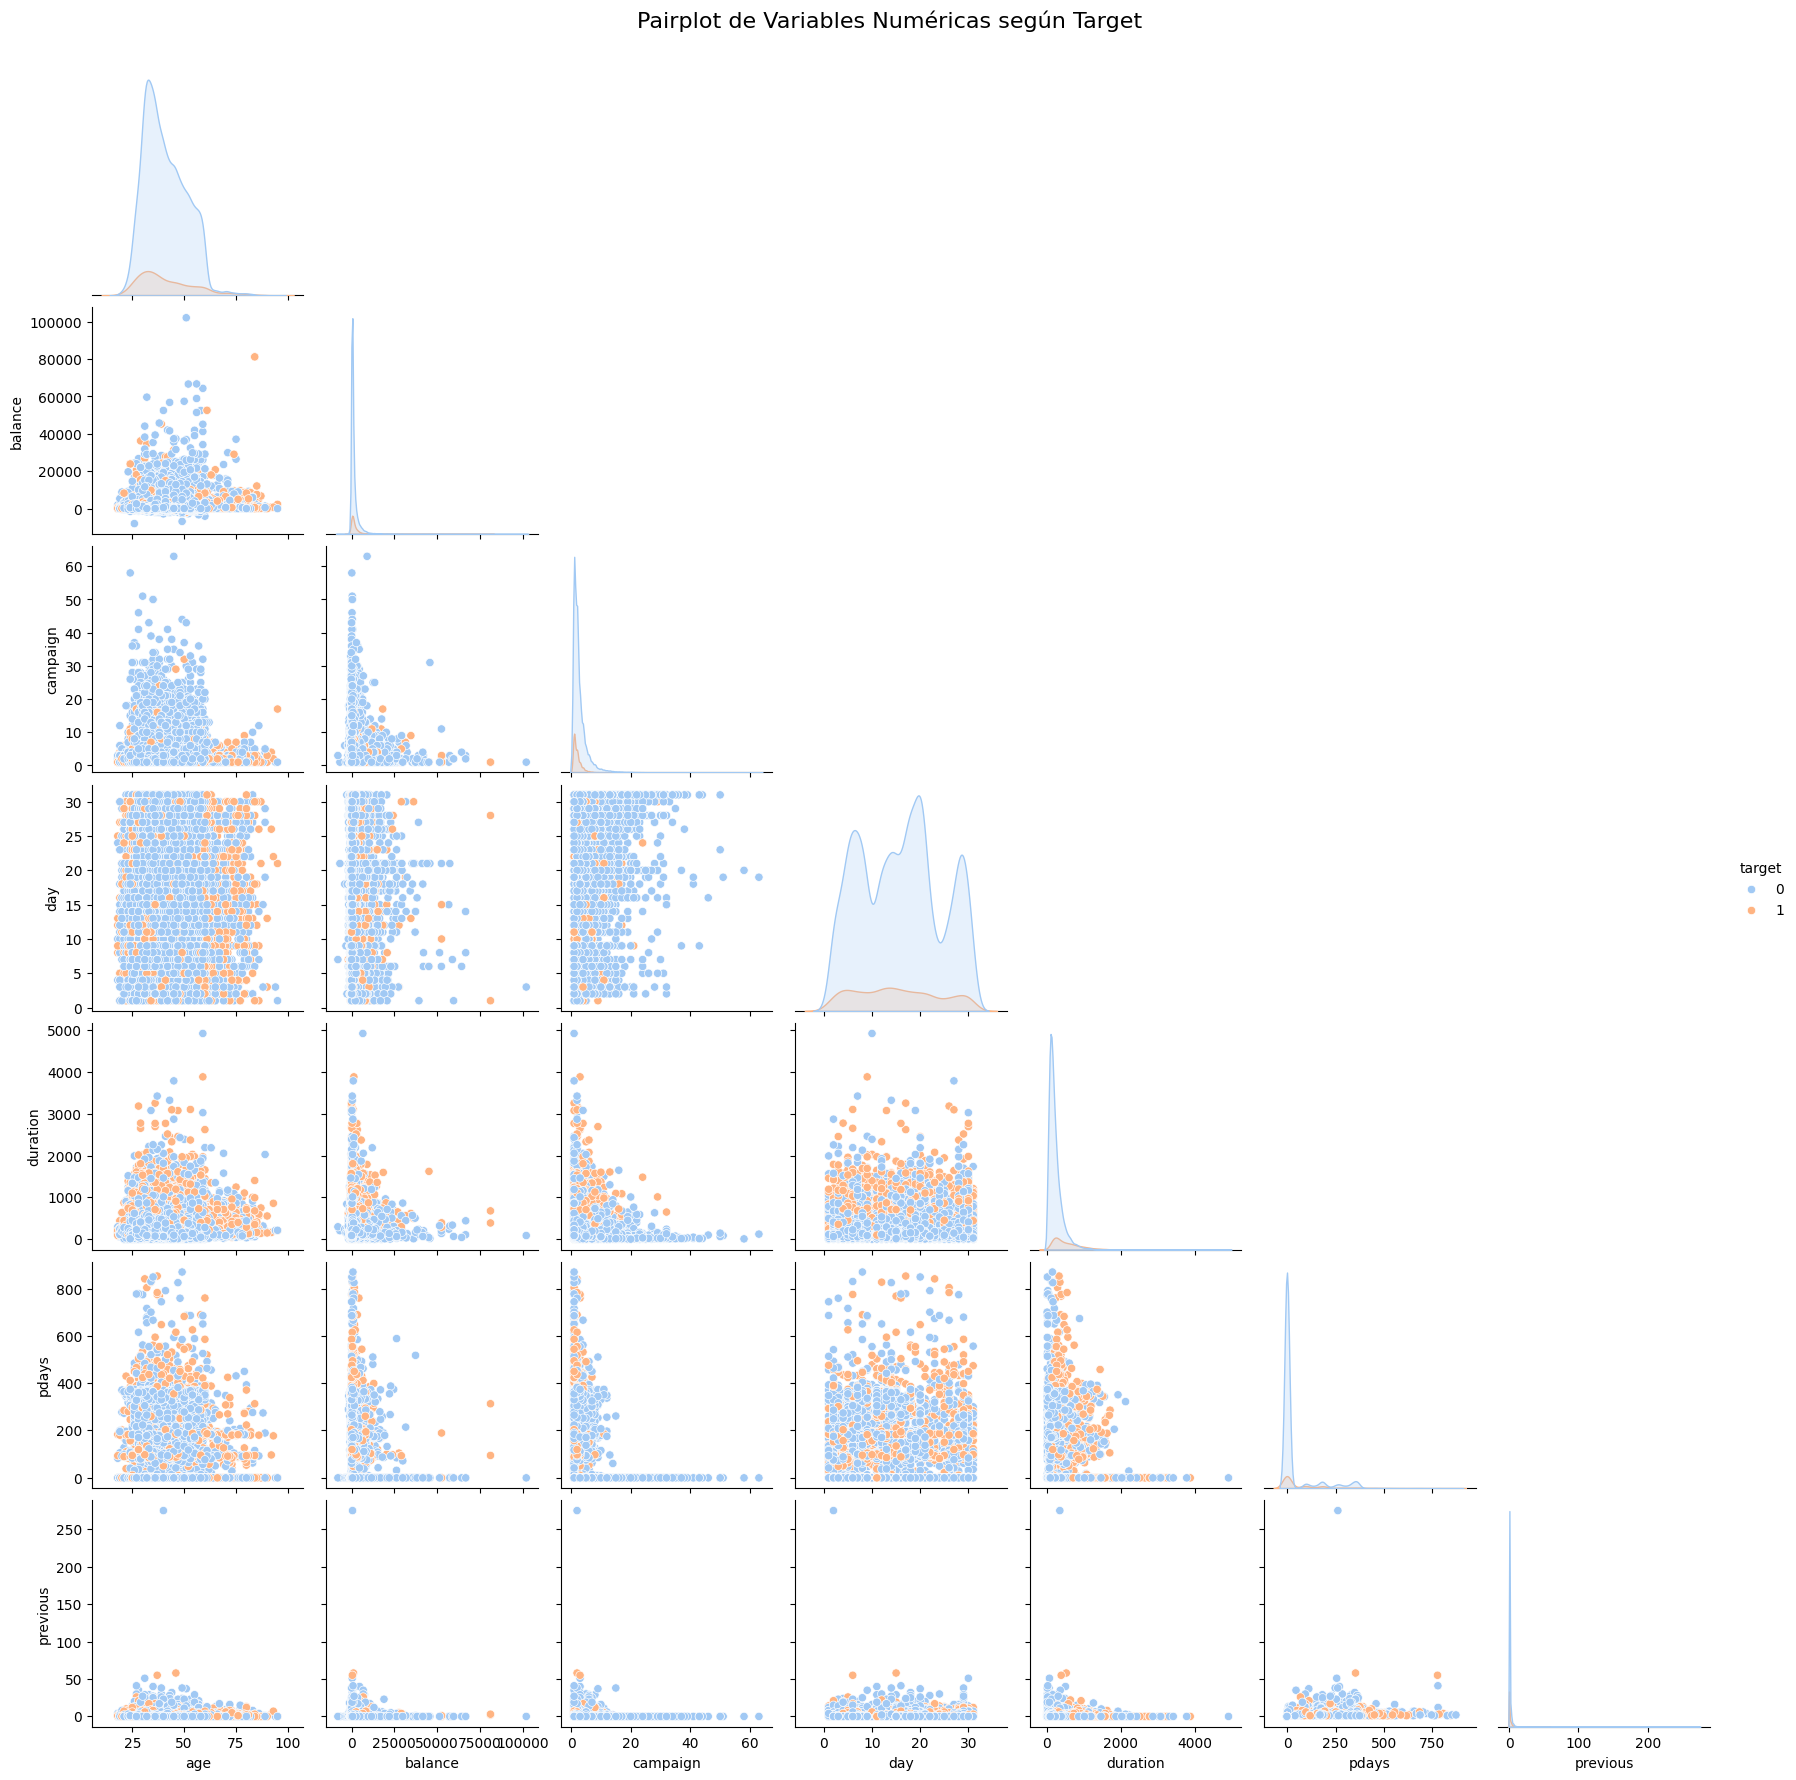

In [14]:
# Crear un pairplot
sns.pairplot(
    train_data[numerical_features.union(['target'])],  # Incluir variables numéricas y la target
    hue='target',  # Diferenciar por la variable target
    palette='pastel',  # Paleta de colores
    diag_kind='kde',  # Gráfico de densidad en la diagonal
    corner=True  # Mostrar sólo la parte inferior del gráfico
)

# Configuración general del gráfico
plt.suptitle("Pairplot de Variables Numéricas según Target", y=1.02, fontsize=16)
plt.show()

* Sólo se va a considerar la variable age

##### Transformación de variables categóricas 

In [15]:
X_train[categorical_features].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [16]:
X_train['job'].value_counts()

job
blue-collar      6866
management       6530
technician       5306
admin.           3662
services         2879
retired          1590
self-employed    1076
entrepreneur     1044
unemployed        918
housemaid         893
student           677
unknown           206
Name: count, dtype: int64

In [17]:
# Aplicar One-Hot Encoding solo a las variables categóricas
X_train_cat_encoded = pd.get_dummies(X_train[categorical_features], drop_first=True).astype('int')
X_test_cat_encoded = pd.get_dummies(X_test[categorical_features], drop_first=True).astype('int')

In [18]:
X_train_cat_encoded

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
13382,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
32641,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3991,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
8068,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
27484,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16952,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
6317,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
34781,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
13679,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [19]:
# Transformación de variables numéricas
scaler = StandardScaler()
X_train['age_scaled'] = scaler.fit_transform(X_train[['age']])
X_test['age_scaled'] = scaler.transform(X_test[['age']])


In [20]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,age_scaled
13382,31,services,married,secondary,no,1,yes,no,cellular,9,jul,82,1,-1,0,unknown,-0.930461
32641,35,services,married,secondary,no,195,yes,no,cellular,17,apr,203,1,-1,0,unknown,-0.553871
3991,24,blue-collar,single,secondary,no,77,yes,no,unknown,16,may,236,2,-1,0,unknown,-1.589493
8068,35,blue-collar,married,secondary,no,80,yes,yes,unknown,2,jun,579,2,-1,0,unknown,-0.553871
27484,37,services,single,secondary,no,105,no,yes,cellular,21,nov,197,2,157,4,failure,-0.365576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16952,45,blue-collar,married,secondary,no,79,yes,no,cellular,25,jul,98,1,-1,0,unknown,0.387603
6317,30,blue-collar,married,secondary,no,1196,no,no,unknown,27,may,147,1,-1,0,unknown,-1.024608
34781,27,management,single,tertiary,no,2559,yes,no,cellular,6,may,227,1,-1,0,unknown,-1.307051
13679,32,housemaid,married,primary,no,0,yes,no,cellular,9,jul,90,1,-1,0,unknown,-0.836314


In [21]:
# Features datasets con variables transformadas
X_train= pd.concat([X_train['age_scaled'], X_train_cat_encoded], axis=1)
X_test= pd.concat([X_test['age_scaled'], X_test_cat_encoded], axis=1)
X_train

,age_scaled,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
13382,-0.930461,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
32641,-0.553871,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3991,-1.589493,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
8068,-0.553871,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
27484,-0.365576,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16952,0.387603,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
6317,-1.024608,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
34781,-1.307051,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
13679,-0.836314,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


##### Entrenamiento clasificador con arbol de decisión, sin ajuste de hiperparámetros y modelo base

In [22]:
# Entrenar un modelo base de árbol de decisión
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = clf.predict(X_test)
print("Accuracy del Árbol de Decisión:", accuracy_score(y_test, y_pred))

Accuracy del Árbol de Decisión: 0.8457682099675612


In [23]:
# Entrenar modelo de regresión logística ----> modelo base
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Evaluar regresión logística
y_pred_log = log_reg.predict(X_test)
print("Accuracy de la Regresión Logística - train:", accuracy_score(y_train, log_reg.predict(X_train)))
print("Accuracy de la Regresión Logística - test:", accuracy_score(y_test, y_pred_log))


Accuracy de la Regresión Logística - train: 0.8917116946314027
Accuracy de la Regresión Logística - test: 0.8942789737540549


In [24]:
# Definir el grid de hiperparámetros 
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, 30, None],  # Más opciones para la profundidad máxima
    'min_samples_split': [2, 5, 10, 15, 20, 30],  # Valores adicionales para el mínimo de muestras por división
    'min_samples_leaf': [1, 2, 4, 8, 16],  # Más opciones para el mínimo de muestras por hoja
    'criterion': ['gini', 'entropy', 'log_loss'],  # Funciones de evaluación disponibles
    'splitter': ['best', 'random'],  # Estrategias de división
    'class_weight': [None, 'balanced']  # Agregar balanceo de clases
}

# Realizar búsqueda en rejilla
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 particiones
    scoring='recall',  # Métrica de evaluación
    verbose=1,  # Mostrar progreso del proceso
    n_jobs=-1   # Usar todos los núcleos disponibles para acelerar el cálculo
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Mejor modelo y resultados
best_tree = grid_search.best_estimator_
print("\nMejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Evaluar el modelo optimizado en el conjunto de prueba
y_pred_optimized = best_tree.predict(X_test) # predecir con el mejor modelo
print("\nAccuracy del Árbol Optimizado en el conjunto de prueba:", accuracy_score(y_test, y_pred_optimized))


Fitting 5 folds for each of 2520 candidates, totalling 12600 fits

Mejores hiperparámetros: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Mejor puntuación de validación cruzada: 0.647487690119269

Accuracy del Árbol Optimizado en el conjunto de prueba: 0.6625626658802714


In [30]:
# Cañcular la feature importance
feature_importance = best_tree.feature_importances_
feature_importance = pd.Series(feature_importance, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)
feature_importance

poutcome_success       0.525479
contact_unknown        0.317361
housing_yes            0.135526
marital_married        0.020449
month_may              0.000764
default_yes            0.000420
month_jan              0.000000
month_aug              0.000000
month_dec              0.000000
month_feb              0.000000
month_jun              0.000000
month_jul              0.000000
loan_yes               0.000000
month_mar              0.000000
month_nov              0.000000
month_oct              0.000000
month_sep              0.000000
poutcome_other         0.000000
contact_telephone      0.000000
age_scaled             0.000000
job_blue-collar        0.000000
education_unknown      0.000000
education_tertiary     0.000000
education_secondary    0.000000
marital_single         0.000000
job_unknown            0.000000
job_unemployed         0.000000
job_technician         0.000000
job_student            0.000000
job_services           0.000000
job_self-employed      0.000000
job_reti

##### Evaluación contra el test

In [141]:
# Métricas de evaluación
print("Reporte de clasificación para el Árbol de Decisión Optimizado:")
print(classification_report(y_test, y_pred_optimized))

print("Reporte de clasificación para la Regresión Logística:")
print(classification_report(y_test, y_pred_log))

# Matrices de confusión
print("Matriz de Confusión - Árbol de Decisión:")
print(confusion_matrix(y_test, y_pred_optimized))

print("Matriz de Confusión - Regresión Logística:")
print(confusion_matrix(y_test, y_pred_log))


Reporte de clasificación para el Árbol de Decisión Optimizado:
              precision    recall  f1-score   support

           0       0.94      0.66      0.78     11977
           1       0.21      0.66      0.31      1587

    accuracy                           0.66     13564
   macro avg       0.57      0.66      0.55     13564
weighted avg       0.85      0.66      0.72     13564

Reporte de clasificación para la Regresión Logística:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11977
           1       0.68      0.18      0.29      1587

    accuracy                           0.89     13564
   macro avg       0.79      0.59      0.62     13564
weighted avg       0.88      0.89      0.87     13564

Matriz de Confusión - Árbol de Decisión:
[[7940 4037]
 [ 540 1047]]
Matriz de Confusión - Regresión Logística:
[[11839   138]
 [ 1296   291]]


In [138]:
# Analizar la distribución de la variable target en el conjunto de entrenamiento
target_fre = y_train.value_counts(normalize=True)
print(f"Distribución de la variable target en el conjunto de entrenamiento:\n{target_fre}")

Distribución de la variable target en el conjunto de entrenamiento:
y
0    0.883022
1    0.116978
Name: proportion, dtype: float64
